In [2]:
"""
Author @Sippapas Sukpholtham
Master's Student in Mechanical and Aerospace Engineering
University of Florida
Dec, 2022

""";

#### Importing all necessary libraries

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


# from CNN.CNN_2 import CNN
from sklearn.metrics import accuracy_score, confusion_matrix


#### Loading Data

In [10]:
# Loading data
raw_data = np.load('data_for_training.npy')
print(raw_data.shape)

data = raw_data[:,:-1]
print(data.shape)

labels = raw_data[:,-1]
print(labels.shape)

(13600, 785)
(13600, 784)
(13600,)


#### Rearranging the data so that we can input the data into a neural network

In [11]:
# Reshaping the dimension before inputting into Neural Network
data = data.reshape(data.shape[0], 28, 28)
data = np.array(data, dtype='int64')
labels = np.array(labels, dtype='int64')

# Convert type of data from numpy to tensor
data = torch.from_numpy(data)
labels = torch.from_numpy(labels)

#### Print the example of the image

tensor(4)


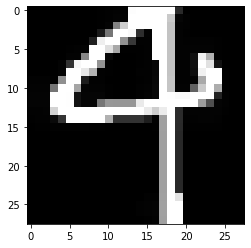

In [12]:
import random
# test = np.array(x_train[0])
N = random.randint(1, 10000)
test = data[N].reshape(28, 28, 1)
plt.imshow(test, cmap='gray')
print(labels[N])

#### Changing the data from numpy to tensor and reshaping the data

In [13]:
# Normalization of test data: shape from (number_of_data, 150, 150) to (number_of_data, 1, 150, 150)
data_test = torch.unsqueeze(data, dim=1).type(torch.FloatTensor)/255
data_test.shape

torch.Size([13600, 1, 28, 28])

#### Convolutional Neural Networks that was designed

In [14]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=32,            # n_filters
                kernel_size=3,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # padding
            ),                              
            nn.BatchNorm2d(32),             # normalization the data
            nn.ReLU(),                      # activation function
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area
            nn.Dropout2d(p=0.3)             # drop out 10% of data
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(32, 64, 3, 1, 2),     
            nn.BatchNorm2d(64),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
            nn.Dropout2d(p=0.3)
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(64, 128, 3, 1, 2),    
            nn.BatchNorm2d(128),
            nn.ReLU(),                      
            nn.MaxPool2d(2),
            nn.Dropout2d(p=0.3)
        )
        self.conv4 = nn.Sequential(         
            nn.Conv2d(128, 128, 3, 1, 2),     
            nn.BatchNorm2d(128),
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
            nn.Dropout2d(p=0.3)
        )
        # self.conv5 = nn.Sequential(         
        #     nn.Conv2d(64, 64, 3, 1, 2),     
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),                      
        #     nn.MaxPool2d(2),                
        #     nn.Dropout2d(p=0.1),
        # )

        self.out1 = nn.Sequential(nn.Linear(1152, 1000), 
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3))
        self.out2 = nn.Sequential(nn.Linear(1000 , 500),  
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3))
        self.out3 = nn.Sequential(nn.Linear(500 , 17))  # last fully connected layer,  output 17 classes

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # x = self.conv5(x)
        x = x.view(x.size(0), -1)  # flatten the output of conv2 to (BATCH_SIZE, 64 * 3 * 3)
        # Linear layers          
        output = self.out1(x)
        output = self.out2(output)
        output = self.out3(output)
        return output, x

# Call the model
cnn = CNN().to(device)

# Download the weights from training
cnn.load_state_dict(torch.load('model1.pth'), strict=True)

<All keys matched successfully>

#### Test the data by using our model

In [16]:
# Testing data
cnn.eval()

pred_y = np.array([])
for step in range(1, int((len(data_test))+1)):
    test_output = cnn(data_test[(step-1):step].to(device))[0]
    _ , prediction = torch.max(test_output, 1)
    pred_y = np.append(pred_y, prediction.cpu().numpy())
    data_test[(step-1):step].to('cpu')

accuracy = accuracy_score(labels, pred_y)
cm = confusion_matrix(labels, pred_y)

print('Test accuracy: %.5f' % accuracy)
print("Confusion matrix of test set : \n",cm)

Test accuracy: 0.99603
Confusion matrix of test set : 
 [[797   0   0   0   0   0   1   0   0   0   0   0   0   0   1   0   1]
 [  0 778   1   1   0   0   0  16   0   0   0   0   0   1   0   3   0]
 [  0   0 797   0   1   0   0   0   0   0   1   0   1   0   0   0   0]
 [  0   0   0 799   0   0   0   0   0   1   0   0   0   0   0   0   0]
 [  0   0   0   0 799   0   0   0   0   0   1   0   0   0   0   0   0]
 [  0   0   0   0   0 798   1   0   0   1   0   0   0   0   0   0   0]
 [  0   0   1   0   0   0 793   0   0   0   0   0   0   0   6   0   0]
 [  0   0   0   0   0   0   0 798   0   0   0   1   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0 799   0   0   0   0   0   1   0   0]
 [  0   0   0   0   0   1   0   0   0 799   0   0   0   0   0   0   0]
 [  0   0   1   0   1   0   0   0   0   0 797   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0 800   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0 800   0   0   0   0]
 [  0   0   0   0   1